In [1]:
import keras.backend as K
from keras import Input, Model, Sequential
from keras.layers import *
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

from matplotlib import pyplot as plt
import json

from sklearn import metrics

import sys
sys.path.append("..")
from generative_models import utils

import metrics_utils

/home/luca/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
def build_classifier():
    model_inputs = Input((timesteps,))
    classified = model_inputs

    classified = Dense(45, activation='relu')(classified)
    classified = Dense(15, activation='relu')(classified)
    classified = Dense(1, activation = 'sigmoid')(classified) 

    classifier = Model(model_inputs, classified, 'classifier')
    classifier.compile(loss='binary_crossentropy', optimizer='adam') 
    return classifier

def evaluate_data(real_data, generated_data, epochs):
    zero_value = metrics_utils.get_mode(real_data)
    
    (x_train, y_train), (x_test, y_test) = metrics_utils.combine_data(real_data, generated_data, split)
    
    step = 0.1
    metrics_utils.postprocess_dataset(x_train, zero_value, step)
    metrics_utils.postprocess_dataset(x_test, zero_value, step)
    
    classifier = build_classifier()
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)
    classifier.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, verbose=1, callbacks=[early_stopping])

    y_pred = classifier.predict(x_test)

    history = {}
    history['f1_score'] = metrics.f1_score(y_test, np.rint(y_pred))
    return history

def run_comparison(real_data, generated_data_filepaths, labels, epochs):
    histories = {}

    for index, filepath in enumerate(generated_data_filepaths):
        print(labels[index])
        generated_data = np.load(filepath)[:elements]
        generated_data = np.around(generated_data, 4)
        history = evaluate_data(real_data, generated_data, epochs)
        histories[labels[index]] = history
    return histories

In [6]:
timesteps = 90
elements = 50000
split = 0.3
epochs = 100

vanilla_color = 'r'
mbd_color = 'g'
packing_color = 'b'

transactions_filepath = '../../datasets/berka_dataset/usable/normalized_transactions_months.npy'
real_data = utils.load_splitted_dataset(transactions_filepath, timesteps)[:elements]

## Models comparison

vanilla
Train on 70000 samples, validate on 30000 samples
Epoch 1/1
70000/70000 [==============================] - 13s 183us/step - loss: 0.6360 - val_loss: 0.6020
mbd
Train on 70000 samples, validate on 30000 samples
Epoch 1/1
70000/70000 [==============================] - 12s 173us/step - loss: 0.0271 - val_loss: 4.1549e-04
packing
Train on 70000 samples, validate on 30000 samples
Epoch 1/1
70000/70000 [==============================] - 12s 172us/step - loss: 0.6271 - val_loss: 0.5960


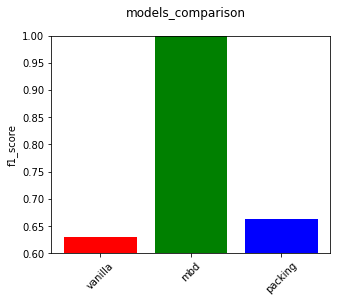

In [7]:
labels = ['vanilla', 'mbd', 'packing']
colors = [vanilla_color, mbd_color, packing_color]
title = 'models_comparison'

base_filepath = '../generative_models/wgan_gp/outputs/final/'
end_filename = 'generated_datasets/1000000_generated_data.npy'    
generated_data_filepaths = []    
for label in labels:
    generated_data_filepaths.append(base_filepath + label + '/' + end_filename)
    
histories = run_comparison(real_data, generated_data_filepaths, labels, epochs)
metrics_utils.plot_metrics(histories, labels, colors, title)

metrics_utils.save_to_json('nn_classification_models_comparison.json', histories)

## Performance analysis during training

In [8]:
labels = ['100k', '200k', '300k', '400k', '500k', '600k', '700k', '800k', '900k', '1M']

transactions_filepath = '../../datasets/berka_dataset/usable/normalized_transactions_months.npy'
real_data = utils.load_splitted_dataset(transactions_filepath, timesteps)[:elements]

### Vanilla

100k
Train on 70000 samples, validate on 30000 samples
Epoch 1/1
70000/70000 [==============================] - 13s 186us/step - loss: 0.6033 - val_loss: 0.5413
200k
Train on 70000 samples, validate on 30000 samples
Epoch 1/1
70000/70000 [==============================] - 12s 171us/step - loss: 0.6299 - val_loss: 0.5734
300k
Train on 70000 samples, validate on 30000 samples
Epoch 1/1
70000/70000 [==============================] - 13s 191us/step - loss: 0.6373 - val_loss: 0.6010
400k
Train on 70000 samples, validate on 30000 samples
Epoch 1/1
70000/70000 [==============================] - 15s 208us/step - loss: 0.6333 - val_loss: 0.6019
500k
Train on 70000 samples, validate on 30000 samples
Epoch 1/1
70000/70000 [==============================] - 15s 214us/step - loss: 0.6314 - val_loss: 0.6158
600k
Train on 70000 samples, validate on 30000 samples
Epoch 1/1
70000/70000 [==============================] - 17s 240us/step - loss: 0.6342 - val_loss: 0.5939
700k
Train on 70000 samples, valid

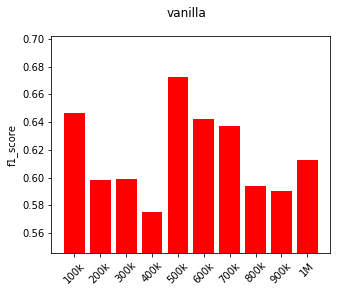

In [9]:
colors = [vanilla_color] * 10
title = 'vanilla'

base_filepath = '../generative_models/wgan_gp/outputs/final/vanilla/generated_datasets/'
generated_data_filepaths = []
for n in range(100000, 1000001, 100000):
    generated_data_filepaths.append(base_filepath + str(n) + '_generated_data.npy')
    
histories = run_comparison(real_data, generated_data_filepaths, labels)
metrics_utils.plot_metrics(histories, labels, colors, title)

metrics_utils.save_to_json('nn_classification_vanilla.json', histories)

### Mbd

In [ ]:
colors = [mbd_color] * 10
title = 'mbd'

base_filepath = '../generative_models/wgan_gp/outputs/final/mbd/generated_datasets/'
generated_data_filepaths = []
for n in range(100000, 1000001, 100000):
    generated_data_filepaths.append(base_filepath + str(n) + '_generated_data.npy')
    
histories = run_comparison(real_data, generated_data_filepaths, labels)
metrics_utils.plot_metrics(histories, labels, colors, title)

metrics_utils.save_to_json('nn_classification_mbd.json', histories)

### Packing

In [ ]:
colors = [packing_color] * 10
title = 'packing'

base_filepath = '../generative_models/wgan_gp/outputs/final/packing/generated_datasets/'
generated_data_filepaths = []
for n in range(100000, 1000001, 100000):
    generated_data_filepaths.append(base_filepath + str(n) + '_generated_data.npy')
    
histories = run_comparison(real_data, generated_data_filepaths, labels)
metrics_utils.plot_metrics(histories, labels, colors, title)

metrics_utils.save_to_json('nn_classification_packing.json', histories)